# Aprendizaje Reforzado: Control de Péndulo Invertido utilizando Deep Deterministic Policy Gradient (DDPG)

En este notebook, se hace uso del DDPG para el control del problema del péndulo invertido. Este problema consiste en mantener una barra de metal en un ángulo de 90° con respecto a la horizontal, al aplicar un torque para generar movimientos angulares en la barra. Dado que tanto el conjunto de estados como el de acciones es **no** finito, es necesario emplear estrategias de aprendizaje profundo.

El método DDPG consiste en implementar redes neuronales para la estimación de las acciones *continuas* dado un estado, representando la *política* $(\mu)$, así como para calcular la función de valor acción-estado $(Q)$, que da el nombre a Q-Learning.

Para la optimización los parámetros de las redes neuronales, se utilizan dos adicionales para el cálculo de las funciones de pérdida. Esto se hace para obtener consistencia y no obtener mínimos globales, que pueden ocurrir al utilizar la misma red neuronal para el ajuste de parámetros.

Dado que las acciones son continuas, no es recomendable utilizar un método como el $\epsilon$-greedy para el problema de exploración y explotación, dado que sería muy exhaustivo encontrar la acción que da el máximo valor $Q$. Por esta razón, se utilizan 2 estrategias para el entrenamiento de la red:

1. Se utiliza un ruido aleatorio $N$, el cual afecta las acciones seleccionadas en una determinada cantidad, con el fin de promover la exploración
2. Se utiliza una memoria $R$ para almacenar los estados y recompensas observados, y las redes neuronales se entrenan tomando muestras aleatorias de dicha memoria. Esto facilita la explotación de resultados obtenidos.

## Redes Neuronales Usadas

- **Actor $(\mu(s|\theta^\mu))$:** Red neuronal para la estimación de acciones dado un estado determinado. Es la base del Modelo de Decisión Markoviano (MDP). En este caso, el modelo es determinístico porque para estado dado, siempre se obtendrá la misma acción. Tanto entradas como salidas son continuas.
- **Crítica $(Q(a, s|\theta^Q))$:** Red neuronal para el cálculo de la función de valor acción-estado. Otorga como resultado el valor $Q$ dado un par de acción-estado. A diferencia de otros métodos de Deep Q-Learning, la salida es un único valor para cada par, lo cual refuerza la idea de política determinística.
- **Actor Objetivo $(\mu\text{*} (s|\theta^{\mu\text{*}}))$:** Red neuronal con la misma arquitectura que la red *Actor*. Esta red neuronal también es usada para el cálculo de acciones dado un estado específico. Sin embargo, esta acción es usada para alimentar la red *Crítica Objetivo*.
- **Crítica Objetivo $(Q\text{*}(a, s|\theta^{Q\text{*}}))$:** Red neuronal usada para el cálculo de funciones de valor acción-estado, que servirán para calcular la pérdida de la red neuronal *Crítica*.

Para la actualización de las redes objetivo, se utiliza un aprendizaje lento en el cual sus pesos se actualizan para que sean similares a los de las redes actor y crítica, con un porcentaje de cambio pequeño para garantizar la consistencia. Otras aproximaciones copian los parámetros cada ciertos pasos de entrenamiento.

## Algoritmo

El algoritmo de aprendizaje es como sigue, de acuerdo con el artículo en el que se describe: *(T. P. Lillicrap et al, "Continuous control with deep reinforcement learning", arXiv:1509.02971v6, 2015)*:

1. Definir redes neuronales Actor $\mu(s|\theta^\mu)$ y Crítica $Q(a, s|\theta^Q)$ con parámetros aleatorios $\theta^\mu$ y $\theta^Q$
2. Inicializar redes objetivo $\mu\text{*}$ y $Q\text{*}$ con parámetros $\theta^{\mu\text{*}} \leftarrow \theta^{\mu\text{*}}$ y $\theta^{Q\text{*}} \leftarrow \theta^Q$
3. Crear memoria de observaciones $R$
Definir un número de episodios. En cada episodio, realizar los siguientes pasos:
    1. Inicializar el ruido aleatorio $N$ para la exploración
    2. Obtener el estado inicial $s_0$
    Definir un número de iteraciones $t$ y ejecutar los siguientes pasos hasta la iteración $T$:
        1. Seleccionar una acción $a_t = \mu(s_t|\theta^\mu) + N_t$ de acuerdo con la política actual y el ruido de exploración
        2. Ejecutar la acción $a_t$ y obtener la recompensa $r_t$ y el nuevo estado $s_{t+1}$
        3. Guardar la observación $(s_t, a_t, r_t, s_{t+1})$ en $R$
        4. Seleccionar un lote de $n$ observaciones $(s_i, a_i, r_i, s_{i+1})$ de $R$. Se puede definir tomar observaciones solo cuando el número de datos en la memoria superan al tamaño del lote.
        5. Calcular $y_i = r_i +\gamma Q\text{*}(\mu\text{*} (s_{t+1}|\theta^{\mu\text{*}}), s_{t+1}|\theta^{Q\text{*}})$ para cada elemento obtenido de la memoria.
        6. Actualizar la red *crítica* minimizando la pérdida $L = \frac{1}{N}\sum_i (y_i-Q(a_i, s_i|\theta^Q))^2$
        7. Actualizar la red de la política *actor* utilizando el gradiente de política:

        $$\nabla_{\theta^\mu} = \frac{1}{N}\sum_i \nabla_aQ(s,a|\theta^Q)\nabla_{\theta^\mu}\mu(s|\theta^\mu)$$

        8. Actualizar las redes objetivo de acuerdo con:

        $$\theta^{\mu\text{*}} \leftarrow \tau\theta^\mu+(1-\tau)\theta^{\mu\text{*}}$$

        $$\theta^{Q\text{*}} \leftarrow \tau\theta^Q +(1-\tau)\theta^Q\text{*}$$

## Implementación

Importar librerías a utilizar durante la simulación del ejercicio. En este caso, se utilizará el entorno *Pendulum* de la librería *gym* para simular el péndulo invertido.

Para la implementación de las redes neruonales, se utilizará la librería *keras* del paquete *Tensorflow*.

In [ ]:
import gym #Librería para el entorno de acción
import numpy as np #Librería para arreglos y cálculos matemáticos
import matplotlib.pyplot as plt #Módulo útil para gráficas necesarias

import tensorflow as tf #Módulo de Tensorflow para el manejo de tensores
from keras import layers #Importar módulo de capas para implementar las redes neuronales

import time #Utilizado para lograr una visualización suave del entorno

A continuación, se realiza la inicialización del entorno. Se obtiene la dimensión de la entrada, correspondiente a la representación del estado, el número de acciones que pueden tomarse en el sistema, y los límites de la acción que pueden realizarse.

In [ ]:
env = gym.make("Pendulum-v0") #Almacenar el entorno en la variable "env". El entorno puede ser "Pendulum-v1" dependiendo de la versión de gym

input_dim = env.observation_space.shape[0] #Número de variables representando el estado del sistema
num_actions = env.action_space.shape[0] #Número de acciones que pueden tomarse en el sistema

#Límite superior e inferior para las acciones
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

### Ruido Aleatorio

Este es el encargado de otorgarle la capacidad de explorar al agente. Se representa mediante un proceso **Ornstein–Uhlenbeck**, el cual representa el movimiento browniano de partículas en su interacción con el medio en el que habitan. La clase *OUActionNoise* permite crear un objeto que almacena el ruido, así como permite reiniciarlo y mantener memoria de los ruidos anteriores.

In [ ]:
class OUActionNoise(object):
    #Clase para el Ruido aleatorio: Esta es la manera en la que el algoritmo alterna entre exploración y explotación:
    #dado que el conjunto de estados y acciones es no finito, es posible agregar un ruido aleatorio a la acción que se va a tomar, y esto implica realizar acciones que no se habían hecho antes.

    #Atributos: mu, sigma, theta, dt, xo
    #Métodos: init, call, reset

    def __init__(self, mu, sigma = 0.2, theta  = 0.15, dt = 1e-2, xo = None):
        #Inicialización del ruido. Asigna los parámetros pasados para la simulación del ruido.
        self.mu = mu
        self.sigma = sigma
        self.theta = theta
        self.dt = dt
        self.xo = xo
        self.reset()

    def __call__(self):
        #Sobreescribe el método call, de tal manera que pueda obtenerse un nuevo ruido con solo llamar el objeto instancia de la clase.
        x = self.x_prev+self.theta*(self.mu-self.x_prev)*self.dt + self.sigma*np.sqrt(self.dt)*np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        #Reinicia el ruido a. valor inicial pasado a la función
        self.x_prev = self.xo if self.xo is not None else np.zeros_like(self.mu)

### Memoria de Repetición

Lista de observaciones de estados, acciones y recompensas, que serán de utilidad para el entrenamiento de las redes. Su implementación es una clase para facilitar el almacenamiento y acceso a los registros.

In [ ]:
class MemoryBuffer():
    #Memoria de repetición: consiste en una serie de arreglos de numpy para almacenar estados, acciones y recompensas
    #que luego serán muestreadas para el entrenamiento de las redes neuronales

    #Atributos: input_shape, num_actions, mem_size, mem_counter, state_memory, action_memory, reward_memory, new_state_memory
    #Métodos: init, store_observation, sample_memory

    def __init__(self, input_shape, num_actions, mem_size = 10000):
        #Inicializa los atributos de la memoria. Aquí se definde su tamaño y se crean los arreglos para almacenar las observaciones
        self.mem_size = mem_size #Cantidad de registros máxima a almacenar
        self.mem_counter = 0 #Contador que permite saber el número de observaciones que han sido almacenadas en la memoria
        
        #Inicialización de los arreglos. Se llenan con ceros para evitar la inicialización aleatoria y posibles errores en el entrenamiento
        self.state_memory = np.zeros((mem_size, input_shape))
        self.action_memory = np.zeros((mem_size, num_actions))
        self.reward_memory = np.zeros(mem_size)
        self.new_state_memory = np.zeros((mem_size, input_shape))

    def store_observation(self, state, action, reward, new_state):
        #Método para almacenar una observación en cada uno de los arreglos de la memoria
        index = self.mem_counter % self.mem_size #Índice donde se almacena cada observación. Se utiliza la función módulo para reemplazar las observaciones más viejas.

        #Se agrega en la posición index la observación en su arreglo correspondiente
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = new_state

        #Se aumenta el contador en uno, cada vez que un registro se almacena
        self.mem_counter = self.mem_counter + 1

    def sample_memory(self, batch_size):
        #Obtener una muestra aleatoria de tamaño batch_size de la memoria existente.
        # Retorna tensores para poder ser alimentados a las redes neuronales definidas con keras.

        max_mem = min(self.mem_counter, self.mem_size) #Si ya se han almacenado más datos que la memoria puede soportar, seleccionar el tamaño de la memoria
        batch = np.random.choice(max_mem, batch_size) #Seleccionar índices aleatorios de acuerdo con el tamaño de la memoria y del lote

        #Almacenar temporalmente las observaciones tomadas aleatoriamente
        states = tf.convert_to_tensor(self.state_memory[batch])
        actions = tf.convert_to_tensor(self.action_memory[batch])
        rewards = tf.convert_to_tensor(self.reward_memory[batch])
        rewards = tf.cast(rewards, dtype = tf.float32) #Es necesario convertir el tipo de datos para ser igual a los demás tensores, ya que Tensorflow por defecto toma valores flotantes como float64
        new_states = tf.convert_to_tensor(self.new_state_memory[batch])

        return states, actions, rewards, new_states #Retorna una tupla con los arreglos con sus muestras aleatorias

### Red Neuronal: Actor

Permite la estimación de una acción de acuerdo a un estado determinado de manera determinista. Posee la siguiente estructura:

- Entradas: Tensor de tamaño *input_dim* que alimenta la siguiente capa
- Capas ocultas: 2 capas ocultas con *h1_dim* y *h2_dim* unidades respectivamente. Los parámetros de ambas capas se inicializan con una distribución uniforme $U(-\frac{1}{\sqrt(f_i)}, \frac{1}{\sqrt(f_i)})$, donde $f_i$ es el número de unidades. La función de activación de ambas es *ReLu*
- Capa de salida: Capa con *num_actions* unidades. Su inicialización se realiza con una distribución uniforme $U(-0.003, 0.003)$ con el fin de obtener salidas cercanas a cero en las primeras etapas del entrenamiento. Su función de activación es *tanh*, de tal manera que se puedan obtener acciones positivas y negativas

In [ ]:
def create_actor():
    #Función para crear la red neuronal actor. Las redes neuronales creadas son determinista, con lo cual se obtiene la misma acción para cada estado determinado.
    
    #Retorna: Modelo de tf.keras, cuyas entradas son las variables que representan el estado, y cuyas salidas son las acciones a tomar.

    h1_dim = 256 #Número de unidades de la primera capa oculta
    h2_dim = 256 #Número de unidades de la segunda capa oculta
        
    #1. Capa de entrada: En este caso, el número de entradas corresponde al número de variables que representan el estado
    state_input = layers.Input(shape = (input_dim,))

    #2. Primera capa oculta: Número de unidades = h1_dim. Función de activación = ReLu
    f1 = 1 / np.sqrt(h1_dim) #Intervalo de inicialización de los parámetros
    
    hidden1 = layers.Dense(h1_dim, #Unidades
        kernel_initializer=tf.random_uniform_initializer(-f1, f1), #Inicialización uniforme de los pesos
        bias_initializer=tf.random_uniform_initializer(-f1,f1), #Inicialización uniforme del bias
        activation='relu')(state_input) #Función de activación ReLu, y entrada definida como el input de la red

    #3. Segunda capa oculta: Número de unidades = h2_dim. Función de activación = ReLu
    f2 = 1 / np.sqrt(h2_dim) #Intervalo de inicialización de los parámetros

    hidden2 = layers.Dense(h2_dim, #Unidades
        kernel_initializer=tf.random_uniform_initializer(-f2,f2), #Inicialización uniforme de los pesos
        bias_initializer=tf.random_uniform_initializer(-f2,f2), #Inicialización uniforme del bias
        activation = 'relu')(hidden1) #Función de activación ReLu, y entrada definida como la salida de la capa oculta 1

    #4. Capa de salida: Número de unidades = num_actions. Función de activación = tanh
    f3 = 0.003 #Se inicializan uniformement distribuidos en este intervalo de tal manera que las acciones iniciales sean cercanas a cero y los gradientes no se desborden en los primeros estados del entrenamiento

    mu = layers.Dense(num_actions, #Número de salidas igual al número de acciones posibles
        kernel_initializer=tf.random_uniform_initializer(-f3,f3), #Inicialización uniforme de los pesos
        bias_initializer=tf.random_uniform_initializer(-f3,f3), #Inicialización uniforme del bias
        activation='tanh')(hidden2) #La salida está restringida entre -1 y 1

    return tf.keras.Model(state_input, mu) #Se retorna un modelo de Keras, en el que la entrada es la representación del estado, y la salida las acciones seleccionadas (determinista)

### Red Neuronal: Crítica

Permite la estimación de la función de valor acción-estado $Q$, de acuerdo con un estado y una acción determinada. Su arquitectura es la siguiente:

1. Entradas: Tensor de variables que representan el estado, y tensor de acciones. Al tensor de acciones se le aplica la función de activación *tanh*.
2. Capas Ocultas: 2 capas ocultas con *h1_dim* y *h2_dim* unidades respectivamente. Los parámetros de ambas capas se inicializan con una distribución uniforme $U(-\frac{1}{\sqrt(f_i)}, \frac{1}{\sqrt(f_i)})$, donde $f_i$ es el número de unidades. La función de activación de ambas es *ReLu*. La entrada a la primera capa oculta es la representación del estado.
3. Capa de Concatenación: Une la salida de la segunda capa oculta y el tensor de acciones alimentado.
4. Capa de salida: Capa con 1 sola salida, representando el valor $Q$ para la combinación estado-acción alimentada. Su función de activación es *ReLu*

In [ ]:
def create_critic():
    #Función para crear la red neuronal crítica, la cual calcula la función de valor Q de acuerdo con un estado y una acción
    #Recibe las salidas de la red Actor y las une para generar el valor Q

    #Retorna: Modelo de tf.keras, cuyas entradas son las variables que representan el estado y las acciones tomadas, y cuyas salidas son las acciones a tomar.

    h1_dim = 16 #Número de unidades de la primera capa oculta
    h2_dim = 32 #Número de unidades de la segunda capa oculta

    #1. Capa de entrada de estados: En este caso, el número de entradas corresponde al número de variables que representan el estado
    state_input = layers.Input(shape=(input_dim,))

    #2. Primera capa oculta: Número de unidades = h2_dim, función de activación = relu
    f1 = 1 / np.sqrt(h1_dim) #Intervalo de inicialización de los parámetros
    
    hidden1 = layers.Dense(h1_dim, #Unidades
        kernel_initializer=tf.random_uniform_initializer(-f1, f1), #Inicialización uniforme de los pesos
        bias_initializer=tf.random_uniform_initializer(-f1,f1), #Inicialización uniforme del bias
        activation='relu')(state_input) #Función de activación ReLu, y entrada definida como el input de la red

    #3. Segunda capa oculta: Número de unidades = h2_dim, función de activación = relu
    f2 = 1 / np.sqrt(h2_dim) #Intervalo de inicialización de los parámetros

    hidden2 = layers.Dense(h2_dim, #Unidades
        kernel_initializer=tf.random_uniform_initializer(-f2,f2), #Inicialización uniforme de los pesos
        bias_initializer=tf.random_uniform_initializer(-f2,f2), #Inicialización uniforme del bias
        activation = 'relu')(hidden1) #Función de activación ReLu, y entrada definida como la salida de la capa oculta 1
    
    #4. Entrada de la acción, obtenida de la red Actor, cuyo tamaño es el número de acciones posibles
    action_input = layers.Input(shape=(num_actions)) 
    action_out = layers.Dense(32, activation="tanh")(action_input) #Se pasan las entradas por una capa con 32 unidades, con función de activación 'tanh'
    
    #5. Capa de Concatenación: Se unen los valores del estado y la acción. Esta será la entrada para la última capa
    state_actions = layers.Concatenate()([hidden2, action_out])

    #6. Capa de salida: Número de unidades: 1. Función de activación: ReLu
    f3 = 0.003 #Intervalo de inicialización de los parámetros
    q = layers.Dense(1, #Solo una salida, representando el valor Q(a,s)
        kernel_initializer=tf.random_uniform_initializer(-f3,f3), #Inicialización uniforme de los pesos
        bias_initializer=tf.random_uniform_initializer(-f3,f3), #Inicialización uniforme del bias
        activation='relu')(state_actions) #Salida con función de activación relu

    return tf.keras.Model([state_input, action_input], q) #Se retorna un modelo de Keras, en el que la entrada es la representación del estado y la acción, y la salida el valor Q (determinista)

### Función de Entrenamiento

En esta función, se realiza el muestreo de la memoria de observaciones, se calculan los gradientes, y se actualizan las 4 redes neuronales presentes en el algoritmo.

In [ ]:
def train():
    #Procedimiento que permite el entrenamiento de las redes neruonales a partir de la memoria de estados que se ha almacenado en cada iteración
    #Dado que es un procedimiento, no se tiene un valor de retorno en la función

    #Seleccionar batch aleatorio de la memoria de tamaño batch_size
    states, actions, rewards, next_states = memory.sample_memory(batch_size)

    #Calcular el gradiente para la red neuronal crítica con las acciones obtenidas por la red actor objetivo mu(s_t+1) y la ecuación de Bellman

    with tf.GradientTape() as tape: #Definir un gradiente donde se almacenará la función de pérdida
        target_actions = target_actor(next_states) #Calcular acciones con la red actor objetivo
        y = rewards + gamma*target_critic([next_states, target_actions]) #Calcular y_i como la recompensa descontada, asumiendo un MDP, con la red neuronal crítica objetivo

        critic_q_values = critic([states, actions]) #Valores Q estimados por la red crítica
        critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_q_values)) #MSE entre los valores Q de la red crítica y la red crítica objetivo
    
    critic_grad = tape.gradient(critic_loss, critic.trainable_variables) #Definir gradiente para la red crítica
    critic_optimizer.apply_gradients(zip(critic_grad, critic.trainable_variables)) #Aplicar el descenso gradiente en los parámetros de la red crítica

    #Calcular el gradiente para la red neuronal actor de acuerdo con el gradiente de política, tomando los valores Q de la red crítica y las acciones de la red actor

    with tf.GradientTape() as tape: #Definir un gradiente donde se almacenará la función de pérdida
            actions = actor(states) #Calcular acciones con la red actor
            critic_value = critic([states, actions]) #Calcular valores Q con la red crítica

            actor_loss = -tf.math.reduce_mean(critic_value) #Se utiliza el negativo de los valores Q, dado que el optimizador de keras busca minimizar la función objetivo

    actor_grad = tape.gradient(actor_loss, actor.trainable_variables) #Definir gradiente para la red actor
    actor_optimizer.apply_gradients(zip(actor_grad, actor.trainable_variables)) #Aplicar el descenso gradiente en los parámetros de la red actor

    #Actualizar los pesos de las redes objetivos de acuerdo con un factor tau
    for (t, a) in zip(target_actor.variables, actor.variables):
        t.assign(a * tau + t * (1 - tau))

    for (t, c) in zip(target_critic.variables, critic.variables):
        t.assign(c * tau + t * (1 - tau))

### Definición de los Parámetros de Ejecución del Entorno

En la siguiente celda, se inicializan todos los hiperparámetros que controlan el entorno, tales como el número de iteraciones, las redes neuronales, las tasas de aprendizaje, el ruido de exploración y la memoria de observaciones.

In [ ]:
#Parámetro para variar el tamaño posible de las salidas. En este caso, se elige tener salidas entre -1 y 1 para obtener respuestas más suaves en el entorno
action_bound = 1 #upper_bound

#Learning rate (alpha) de cada una de las redes neuronales. Los valores establecidos inicialmente corresponden a los reportados en el artículo de Lillicrap
actor_learning_rate = 0.001
critic_learning_rate = 0.002

gamma = 0.99 #Tasa de descuento de la recompensa futura
tau = 0.001 #Factor para actualizar los parámetros de las redes objetivo

#Número de episodios e iteraciones a ser llevados a cabo en el entorno
total_episodes = 100
total_iterations = 200

#Tamaño de muestreo de la memoria, e inicialización de la memoria de observaciones R
batch_size = 64
memory = MemoryBuffer(input_dim, num_actions, 1000) #Se establece la memoria con el número de variables que representan el estado, y el número de acciones posibles

#Crear las redes neuronales Actor y Crítica
actor = create_actor()
critic = create_critic()

#Creación de las redes neuronales objetivo
target_actor = create_actor()
target_critic = create_critic()

#Inicializar los parámetros de las redes objetivo igual a los parámetros de las redes actor y crítica
target_actor.set_weights(actor.get_weights())
target_critic.set_weights(critic.get_weights())

#Inicializar optimizadores. En este caso, se utiliza el optimizador Adam, el más utilizado en este tipo de problemas
actor_optimizer = tf.keras.optimizers.Adam(actor_learning_rate)
critic_optimizer = tf.keras.optimizers.Adam(critic_learning_rate)

#Inicializar ruido para las acciones para balancear la exploración y la explotación
noise = OUActionNoise(mu = np.zeros(num_actions))

### Ciclo de Entrenamiento

En este ciclo, se llevan a cabo el número establecido de iteraciones en cada uno de los episodios. Adicional a esto, se determinan las acciones a tomar de acuerdo con la política, y se llama a la función *train* para la actualización de los parámetros.

Con el fin de evaluar el rendimiento del entrenamiento, se almacenan las recompensas por estado y se calcula la recompensa promedio de estados anteriores.

Recompensa del episodio: 0 = -1505.0323486328125
Recompensa del episodio: 1 = -1422.99072265625
Recompensa del episodio: 2 = -1197.6895751953125
Recompensa del episodio: 3 = -1286.96728515625
Recompensa del episodio: 4 = -1197.935791015625
Recompensa del episodio: 5 = -1273.8480224609375
Recompensa del episodio: 6 = -1230.439208984375
Recompensa del episodio: 7 = -1290.8837890625
Recompensa del episodio: 8 = -1296.73876953125
Recompensa del episodio: 9 = -1325.1317138671875
Recompensa del episodio: 10 = -1263.8653564453125
Recompensa del episodio: 11 = -1258.145751953125
Recompensa del episodio: 12 = -1280.552978515625
Recompensa del episodio: 13 = -1303.725341796875
Recompensa del episodio: 14 = -1328.3505859375
Recompensa del episodio: 15 = -1279.689697265625
Recompensa del episodio: 16 = -1302.671142578125
Recompensa del episodio: 17 = -1225.6854248046875
Recompensa del episodio: 18 = -1181.9241943359375
Recompensa del episodio: 19 = -1099.3770751953125
Recompensa del episodio: 20 =

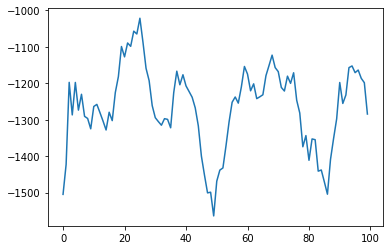

In [ ]:
ep_reward_list = [] #Lista para almacenar la recompensa total de cada episodio
avg_rewards = [] #Lista para almacenar las recompensas promedias de cada episodio

#Ciclo de entrenamiento. Se ejecutan un total de total_episodes.
for ep in np.arange(total_episodes):
    #En cada episodio, se reinicia el entorno y el ruido de exploración, así como la recompensa total por episodio
    current_state = env.reset()
    noise.reset()
    ep_reward = 0

    #Ciclo de iteraciones: dado que el entorno no tiene un estado terminal, se determina el número de iteraciones antes de pasar al siguiente episodio
    for i in np.arange(total_iterations):
        #env.render() #Descomentar para mirar el entrenamiento en tiempo real
        #time.sleep(0.1) #Tiempo entre fotogramas para observar el entrenamiento

        #Obtener una acción de acuerdo con la política actual, y escalarla de acuerdo a los límites establecidos por la acción
        action = tf.multiply(actor(tf.convert_to_tensor([current_state])), action_bound)

        #Obtener siguiente estado después de aplicar la acción junto con su recompensa. 
        next_state, reward, done, info = env.step(action + noise()) #Nótese que se agrega el ruido de exploración

        #Guardar observación en la memoria
        memory.store_observation(current_state.reshape(3), action, reward, next_state.reshape(3))

        #Llama al procedimiento para calcular las funciones de pérdida y actualizar los parámetros de las redes
        train()

        #Aumenta la recompensa del episodio actual
        ep_reward = ep_reward + reward

        #Actualiza el estado para la siguiente iteración
        current_state = next_state
    
    ep_reward_list.append(ep_reward) #Agrega la recompensa total a la lista

    avg_rewards.append(np.mean(ep_reward_list[-10:])) #Agrega el promedio de los últimos 10 episodios a la lista

    print("Recompensa del episodio: {} = {}".format(ep, np.mean(ep_reward_list[-10:]))) #Función para realizar seguimiento al entrenamiento del modelo, y la recompensa promedio


plt.plot(avg_rewards) #Grafica la recompensa promedio de los episodios anteriores.
plt.show()

Se puede observar que la recompensa promedio de los episodios aumenta conforme se realizan más pruebas y se ajusta más el modelo. Con el fin de mirar el desempeño del agente, se procede a realizar una validación sin tener en cuenta el ruido de la exploración.

### Validación del Modelo

En la siguiente celda, se realiza un episodio para verificar la política aprendida por el agente en el entorno estudiado.

In [ ]:
current_state = env.reset() #Se reinicia el estado del entorno
test_reward = 0

#Ciclo para observar el comportamiento del agente, luego de haber aprendido la política
for i in np.arange(total_iterations):
    #env.render() #Mostrar el comportamiento del agente en tiempo real
    
    #Obtener acción de acuerdo con la política aprendida. Nótese que ahora no se incluye el ruido de exploración.
    action = tf.multiply(actor(tf.convert_to_tensor([current_state])), action_bound)

    #Aplicar la acción para obtener el siguiente estado
    next_state, reward, done, info = env.step(action)

    #Aumentar la recompensa del test
    test_reward += reward

    #Actualizar el estado para la siguiente iteración
    current_state = next_state

print('Recompensa total de la prueba: ', test_reward)

Recompensa total de la prueba:  [-1311.7986]


### Análisis de Sensibilidad de los Parámetros

Otra manera de evaluar el desempeño del modelo, es variar los hiperparámetros usados. En este caso, se analizará el impacto de las tasas de aprendizaje, la tasa de descuento y el factor de actualización tau, las cuales se presentan como críticas en este tipo de aplicaciones.

#### Tasa de Aprendizaje

In [ ]:
action_bound = 1 #upper_bound

#Se realiza un cambio en el learning rate de la red actor y la red crítica
actor_learning_rate = 0.1
critic_learning_rate = 0.2

gamma = 0.99
tau = 0.001

total_episodes = 100
total_iterations = 200

batch_size = 64
memory = MemoryBuffer(input_dim, num_actions, 1000)

#Crear las redes neuronales
actor = create_actor()
critic = create_critic()

target_actor = create_actor()
target_critic = create_critic()

target_actor.set_weights(actor.get_weights())
target_critic.set_weights(critic.get_weights())

actor_optimizer = tf.keras.optimizers.Adam(actor_learning_rate)
critic_optimizer = tf.keras.optimizers.Adam(critic_learning_rate)

noise = OUActionNoise(mu = np.zeros(num_actions))

Recompensa del episodio: 0 = -1630.8226318359375
Recompensa del episodio: 1 = -1553.2589111328125
Recompensa del episodio: 2 = -1380.1593017578125
Recompensa del episodio: 3 = -1294.7474365234375
Recompensa del episodio: 4 = -1299.938232421875
Recompensa del episodio: 5 = -1342.527587890625
Recompensa del episodio: 6 = -1334.7078857421875
Recompensa del episodio: 7 = -1266.4075927734375
Recompensa del episodio: 8 = -1302.6004638671875
Recompensa del episodio: 9 = -1296.049560546875
Recompensa del episodio: 10 = -1231.2569580078125
Recompensa del episodio: 11 = -1190.6575927734375
Recompensa del episodio: 12 = -1206.8109130859375
Recompensa del episodio: 13 = -1273.2906494140625
Recompensa del episodio: 14 = -1238.0162353515625
Recompensa del episodio: 15 = -1233.1925048828125
Recompensa del episodio: 16 = -1237.3682861328125
Recompensa del episodio: 17 = -1289.7960205078125
Recompensa del episodio: 18 = -1258.4970703125
Recompensa del episodio: 19 = -1242.186279296875
Recompensa del ep

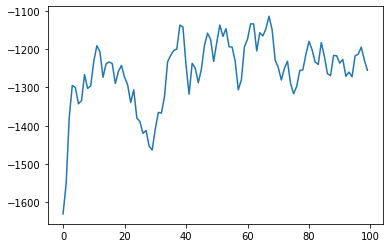

In [ ]:
ep_reward_list = [] #Lista para almacenar la recompensa total de cada episodio
avg_rewards = [] #Lista para almacenar las recompensas promedias de cada episodio

#Ciclo de entrenamiento. Se ejecutan un total de total_episodes.
for ep in np.arange(total_episodes):
    #En cada episodio, se reinicia el entorno y el ruido de exploración, así como la recompensa total por episodio
    current_state = env.reset()
    noise.reset()
    ep_reward = 0

    #Ciclo de iteraciones: dado que el entorno no tiene un estado terminal, se determina el número de iteraciones antes de pasar al siguiente episodio
    for i in np.arange(total_iterations):
        #env.render() #Descomentar para mirar el entrenamiento en tiempo real
        #time.sleep(0.1) #Tiempo entre fotogramas para observar el entrenamiento

        #Obtener una acción de acuerdo con la política actual, y escalarla de acuerdo a los límites establecidos por la acción
        action = tf.multiply(actor(tf.convert_to_tensor([current_state])), action_bound)

        #Obtener siguiente estado después de aplicar la acción junto con su recompensa. 
        next_state, reward, done, info = env.step(action + noise()) #Nótese que se agrega el ruido de exploración

        #Guardar observación en la memoria
        memory.store_observation(current_state.reshape(3), action, reward, next_state.reshape(3))

        #Llama al procedimiento para calcular las funciones de pérdida y actualizar los parámetros de las redes
        train()

        #Aumenta la recompensa del episodio actual
        ep_reward = ep_reward + reward

        #Actualiza el estado para la siguiente iteración
        current_state = next_state
    
    ep_reward_list.append(ep_reward) #Agrega la recompensa total a la lista

    avg_rewards.append(np.mean(ep_reward_list[-10:])) #Agrega el promedio de los últimos 10 episodios a la lista

    print("Recompensa del episodio: {} = {}".format(ep, np.mean(ep_reward_list[-10:]))) #Función para realizar seguimiento al entrenamiento del modelo, y la recompensa promedio


plt.plot(avg_rewards) #Grafica la recompensa promedio de los episodios anteriores.
plt.show()

Se puede observar que la nueva tasa de aprendizaje induce cambios muy bruscos entre cada uno de los episodios. Esto debido a la sensibilidad que tiene el modelo utilizado, para el cual se ha demostrado que el aprendizaje debe hacerse de manera parsimoniosa con el fin de obtener convergencia.

#### Tasa de Descuento de la Recompensa

En este caso, se analiza el cambio en la tasa de descuento de la recompensa. Se utilizará un valor de 0.6, con lo cual se dará un poco más de importancia a la recompensa futura.

In [ ]:
action_bound = 1 #upper_bound

#Se regresan los learning rates a sus valores originales
actor_learning_rate = 0.001
critic_learning_rate = 0.002

gamma = 0.6 #Se realiza el cambio a la tasa de descuento para evaluar su impacto en los resultados
tau = 0.001

total_episodes = 100
total_iterations = 200

batch_size = 64
memory = MemoryBuffer(input_dim, num_actions, 1000)

#Crear las redes neuronales
actor = create_actor()
critic = create_critic()

target_actor = create_actor()
target_critic = create_critic()

target_actor.set_weights(actor.get_weights())
target_critic.set_weights(critic.get_weights())

actor_optimizer = tf.keras.optimizers.Adam(actor_learning_rate)
critic_optimizer = tf.keras.optimizers.Adam(critic_learning_rate)

noise = OUActionNoise(mu = np.zeros(num_actions))

Recompensa del episodio: 0 = -1496.7801513671875
Recompensa del episodio: 1 = -1475.515869140625
Recompensa del episodio: 2 = -1383.1204833984375
Recompensa del episodio: 3 = -1382.9951171875
Recompensa del episodio: 4 = -1398.832275390625
Recompensa del episodio: 5 = -1435.6534423828125
Recompensa del episodio: 6 = -1369.4991455078125
Recompensa del episodio: 7 = -1392.20068359375
Recompensa del episodio: 8 = -1347.34521484375
Recompensa del episodio: 9 = -1317.1025390625
Recompensa del episodio: 10 = -1288.08642578125
Recompensa del episodio: 11 = -1220.069091796875
Recompensa del episodio: 12 = -1282.010498046875
Recompensa del episodio: 13 = -1261.8701171875
Recompensa del episodio: 14 = -1206.30615234375
Recompensa del episodio: 15 = -1174.6453857421875
Recompensa del episodio: 16 = -1212.702392578125
Recompensa del episodio: 17 = -1235.1055908203125
Recompensa del episodio: 18 = -1280.281005859375
Recompensa del episodio: 19 = -1337.0469970703125
Recompensa del episodio: 20 = -13

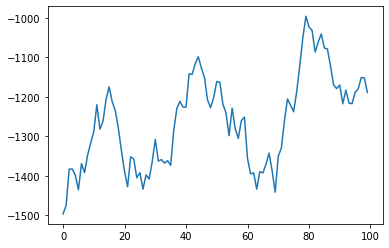

In [ ]:
ep_reward_list = [] #Lista para almacenar la recompensa total de cada episodio
avg_rewards = [] #Lista para almacenar las recompensas promedias de cada episodio

#Ciclo de entrenamiento. Se ejecutan un total de total_episodes.
for ep in np.arange(total_episodes):
    #En cada episodio, se reinicia el entorno y el ruido de exploración, así como la recompensa total por episodio
    current_state = env.reset()
    noise.reset()
    ep_reward = 0

    #Ciclo de iteraciones: dado que el entorno no tiene un estado terminal, se determina el número de iteraciones antes de pasar al siguiente episodio
    for i in np.arange(total_iterations):
        #env.render() #Descomentar para mirar el entrenamiento en tiempo real
        #time.sleep(0.1) #Tiempo entre fotogramas para observar el entrenamiento

        #Obtener una acción de acuerdo con la política actual, y escalarla de acuerdo a los límites establecidos por la acción
        action = tf.multiply(actor(tf.convert_to_tensor([current_state])), action_bound)

        #Obtener siguiente estado después de aplicar la acción junto con su recompensa. 
        next_state, reward, done, info = env.step(action + noise()) #Nótese que se agrega el ruido de exploración

        #Guardar observación en la memoria
        memory.store_observation(current_state.reshape(3), action, reward, next_state.reshape(3))

        #Llama al procedimiento para calcular las funciones de pérdida y actualizar los parámetros de las redes
        train()

        #Aumenta la recompensa del episodio actual
        ep_reward = ep_reward + reward

        #Actualiza el estado para la siguiente iteración
        current_state = next_state
    
    ep_reward_list.append(ep_reward) #Agrega la recompensa total a la lista

    avg_rewards.append(np.mean(ep_reward_list[-10:])) #Agrega el promedio de los últimos 10 episodios a la lista

    print("Recompensa del episodio: {} = {}".format(ep, np.mean(ep_reward_list[-10:]))) #Función para realizar seguimiento al entrenamiento del modelo, y la recompensa promedio


plt.plot(avg_rewards) #Grafica la recompensa promedio de los episodios anteriores.
plt.show()

Los resultados obtenidos son similares a los obtenidos al variar la tasa de aprendizaje, mostrando que los resultados de este modelo tienen una alta sensibilidad con respecto a los parámetros del mismo. En este caso, se ven grandes variaciones a través de los episodios conforme el algoritmo aprende.

#### Tasa de Actualización de las Redes Objetivo

Para finalizar con el análisis de sensibilidad, se procede a realizar cambios en el parámetro $\tau$. Este es el parámetro más importante en la modelación, dado que determina la tasa de cambio de las redes objetivo, y puede llevar a inconsistencias en los resultados. Para este caso, se le da un valor de 0.1, con lo cual los parámetros cambiarán más rápidamente.

In [ ]:
action_bound = 1 #upper_bound

actor_learning_rate = 0.001
critic_learning_rate = 0.002

gamma = 0.99 #Se regresa la tasa de descuento a su valor original
tau = 0.1 #Se cambia el parámetro de actualización de las redes objetivo

total_episodes = 100
total_iterations = 200

batch_size = 64
memory = MemoryBuffer(input_dim, num_actions, 1000)

#Crear las redes neuronales
actor = create_actor()
critic = create_critic()

target_actor = create_actor()
target_critic = create_critic()

target_actor.set_weights(actor.get_weights())
target_critic.set_weights(critic.get_weights())

actor_optimizer = tf.keras.optimizers.Adam(actor_learning_rate)
critic_optimizer = tf.keras.optimizers.Adam(critic_learning_rate)

noise = OUActionNoise(mu = np.zeros(num_actions))

Recompensa del episodio: 0 = -1553.5108642578125
Recompensa del episodio: 1 = -1431.27978515625
Recompensa del episodio: 2 = -1432.4541015625
Recompensa del episodio: 3 = -1503.271484375
Recompensa del episodio: 4 = -1457.238037109375
Recompensa del episodio: 5 = -1517.8851318359375
Recompensa del episodio: 6 = -1439.8770751953125
Recompensa del episodio: 7 = -1466.1444091796875
Recompensa del episodio: 8 = -1433.5382080078125
Recompensa del episodio: 9 = -1364.7161865234375
Recompensa del episodio: 10 = -1306.0445556640625
Recompensa del episodio: 11 = -1336.9674072265625
Recompensa del episodio: 12 = -1323.0635986328125
Recompensa del episodio: 13 = -1287.6226806640625
Recompensa del episodio: 14 = -1237.7232666015625
Recompensa del episodio: 15 = -1205.1959228515625
Recompensa del episodio: 16 = -1252.144775390625
Recompensa del episodio: 17 = -1239.900390625
Recompensa del episodio: 18 = -1269.9927978515625
Recompensa del episodio: 19 = -1302.0372314453125
Recompensa del episodio: 

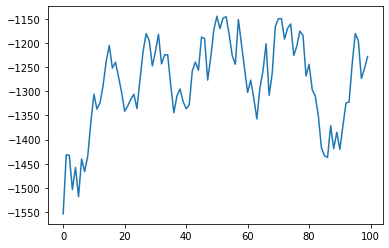

In [ ]:
ep_reward_list = [] #Lista para almacenar la recompensa total de cada episodio
avg_rewards = [] #Lista para almacenar las recompensas promedias de cada episodio

#Ciclo de entrenamiento. Se ejecutan un total de total_episodes.
for ep in np.arange(total_episodes):
    #En cada episodio, se reinicia el entorno y el ruido de exploración, así como la recompensa total por episodio
    current_state = env.reset()
    noise.reset()
    ep_reward = 0

    #Ciclo de iteraciones: dado que el entorno no tiene un estado terminal, se determina el número de iteraciones antes de pasar al siguiente episodio
    for i in np.arange(total_iterations):
        #env.render() #Descomentar para mirar el entrenamiento en tiempo real
        #time.sleep(0.1) #Tiempo entre fotogramas para observar el entrenamiento

        #Obtener una acción de acuerdo con la política actual, y escalarla de acuerdo a los límites establecidos por la acción
        action = tf.multiply(actor(tf.convert_to_tensor([current_state])), action_bound)

        #Obtener siguiente estado después de aplicar la acción junto con su recompensa. 
        next_state, reward, done, info = env.step(action + noise()) #Nótese que se agrega el ruido de exploración

        #Guardar observación en la memoria
        memory.store_observation(current_state.reshape(3), action, reward, next_state.reshape(3))

        #Llama al procedimiento para calcular las funciones de pérdida y actualizar los parámetros de las redes
        train()

        #Aumenta la recompensa del episodio actual
        ep_reward = ep_reward + reward

        #Actualiza el estado para la siguiente iteración
        current_state = next_state
    
    ep_reward_list.append(ep_reward) #Agrega la recompensa total a la lista

    avg_rewards.append(np.mean(ep_reward_list[-10:])) #Agrega el promedio de los últimos 10 episodios a la lista

    print("Recompensa del episodio: {} = {}".format(ep, np.mean(ep_reward_list[-10:]))) #Función para realizar seguimiento al entrenamiento del modelo, y la recompensa promedio


plt.plot(avg_rewards) #Grafica la recompensa promedio de los episodios anteriores.
plt.show()

Los resultados obtenidos en esta simulación muestran grandes variaciones en las etapas tempranas del entrenamiento. Sin embargo, conforme aumentan los episodios, se puede observar que la recompensa promedio de los episodios aumenta. Esto tiene sentido debido a la rapidez con la que varían los parámetros de las redes objetivo, y por tanto las funciones de valor tienden a variar en mayor medida.

Luego de realizar este análisis, se concluye que los parámetros tienen una gran influencia en los resultados obtenidos en el desempeño del método DDPG. Por esta razón, se decide mantener los parámetros iniciales, correspondientes a un aprendizaje de parámetros lento, lo que permite que se tengan resultados consistentes, y no se se encuentren fácilmente mínimos locales.